In [1]:
#IMPORT LIBRARIES
import numpy as np 
import pandas as pd 
import scipy
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats
from numpy import linalg
from numpy import exp

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import keras
from keras.utils.np_utils import to_categorical

%matplotlib inline

2022-11-05 17:36:17.716427: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#MATPLOTLIB SETTINGS
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

In [3]:
#RETREIVE INPUT FILES
path = "/Users/annettechan/thesis/MIT-BIH Database/6-10-22/mitbih_database/"
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

In [4]:
#SORT FILE TYPES
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

In [5]:
#DENOISING FUNCTION
def denoise(data): 
    w = pywt.Wavelet('db6')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.03 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'db6', level=6)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'db6')
    
    return datarec

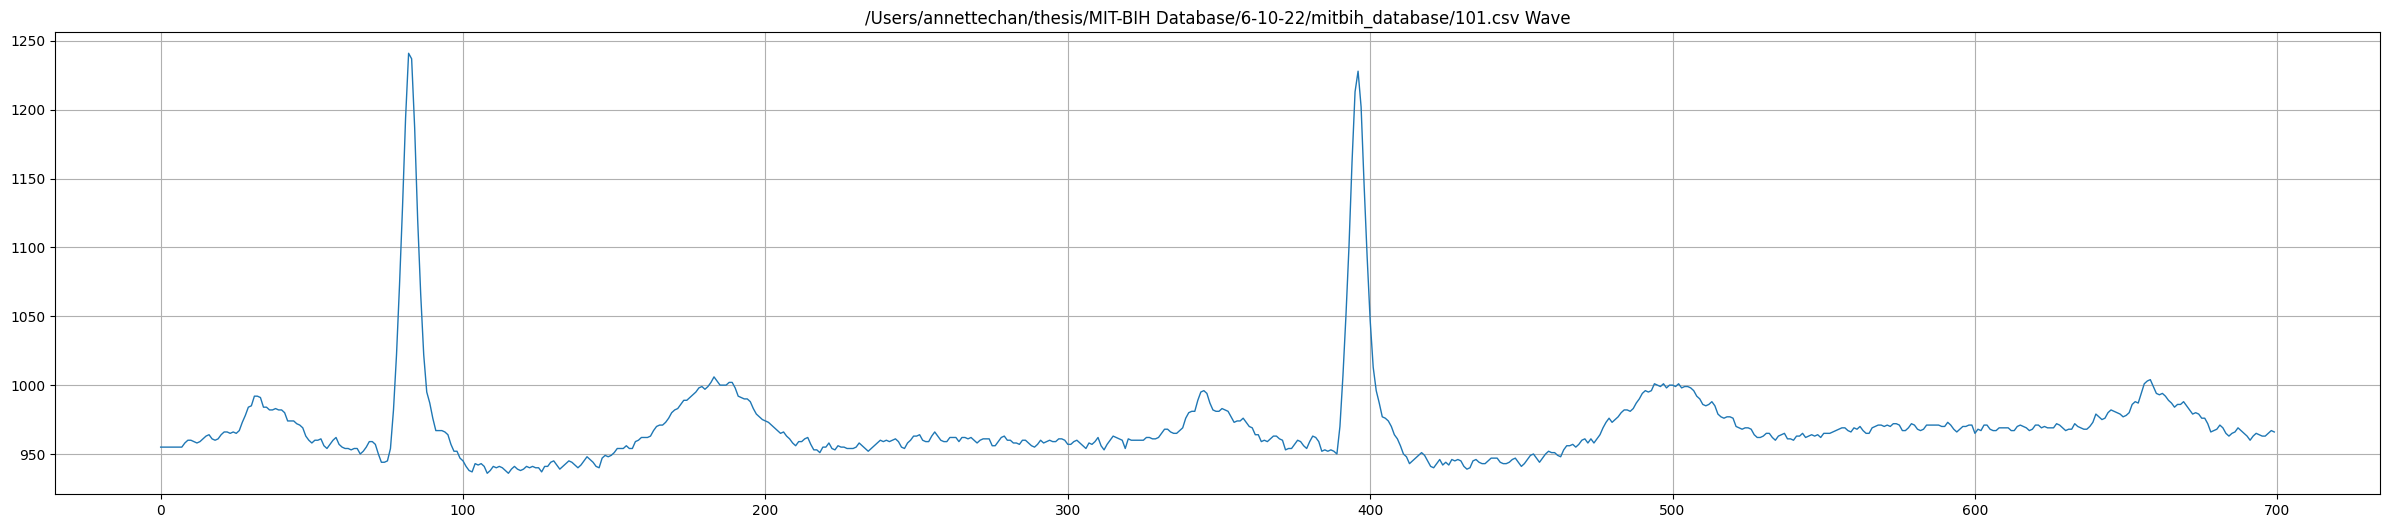

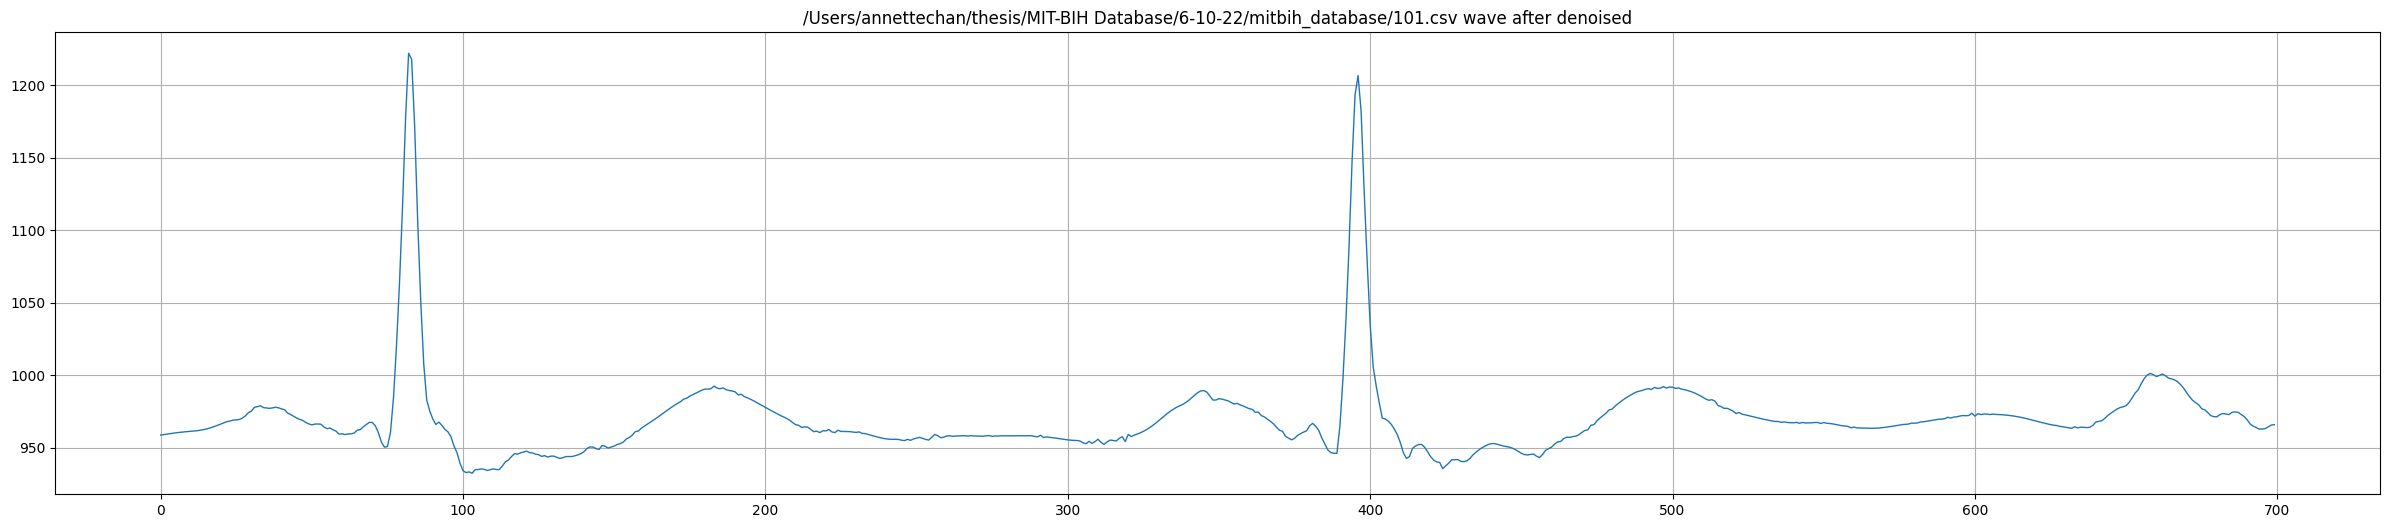

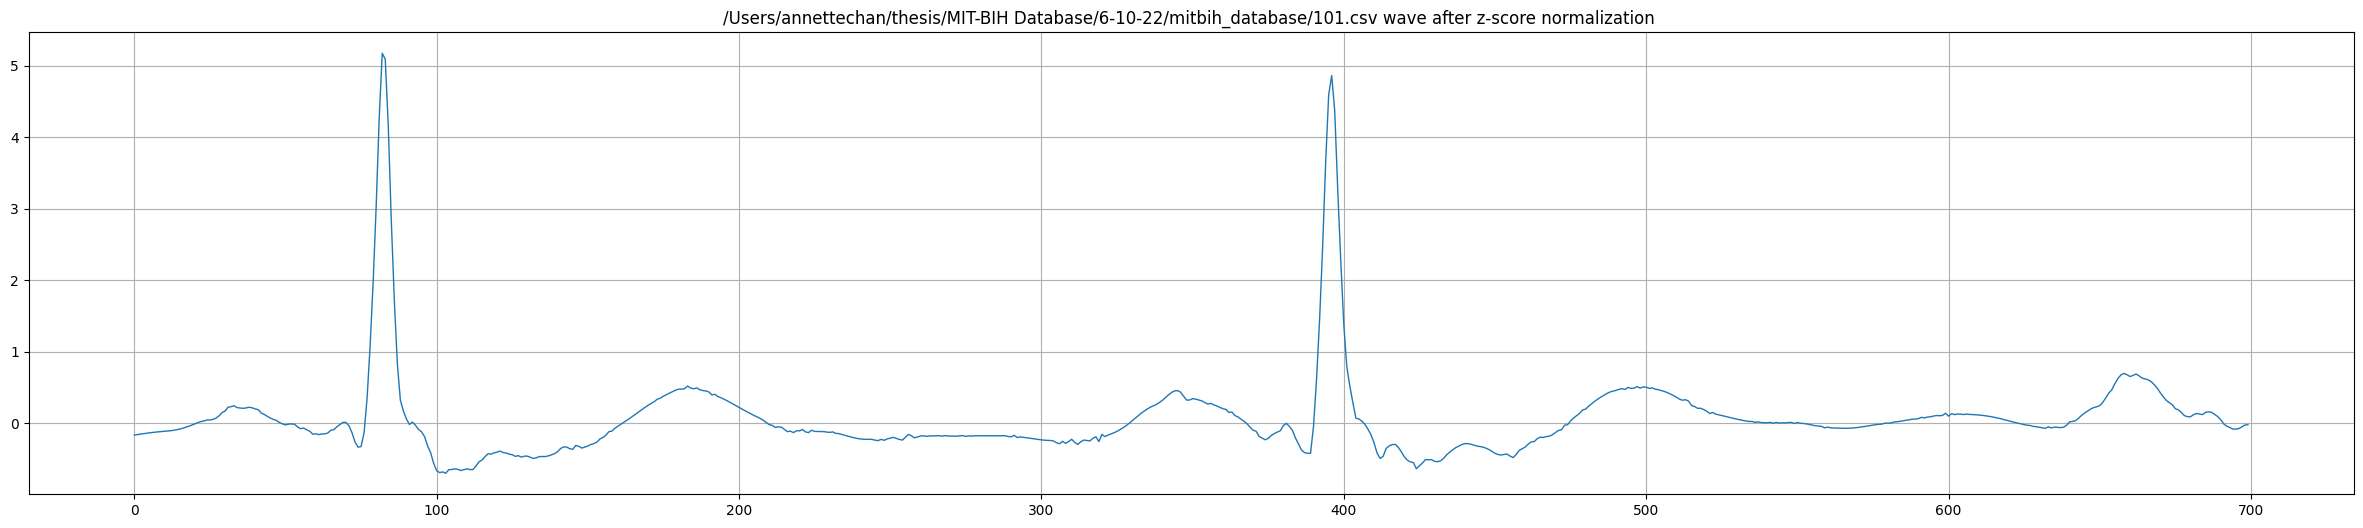

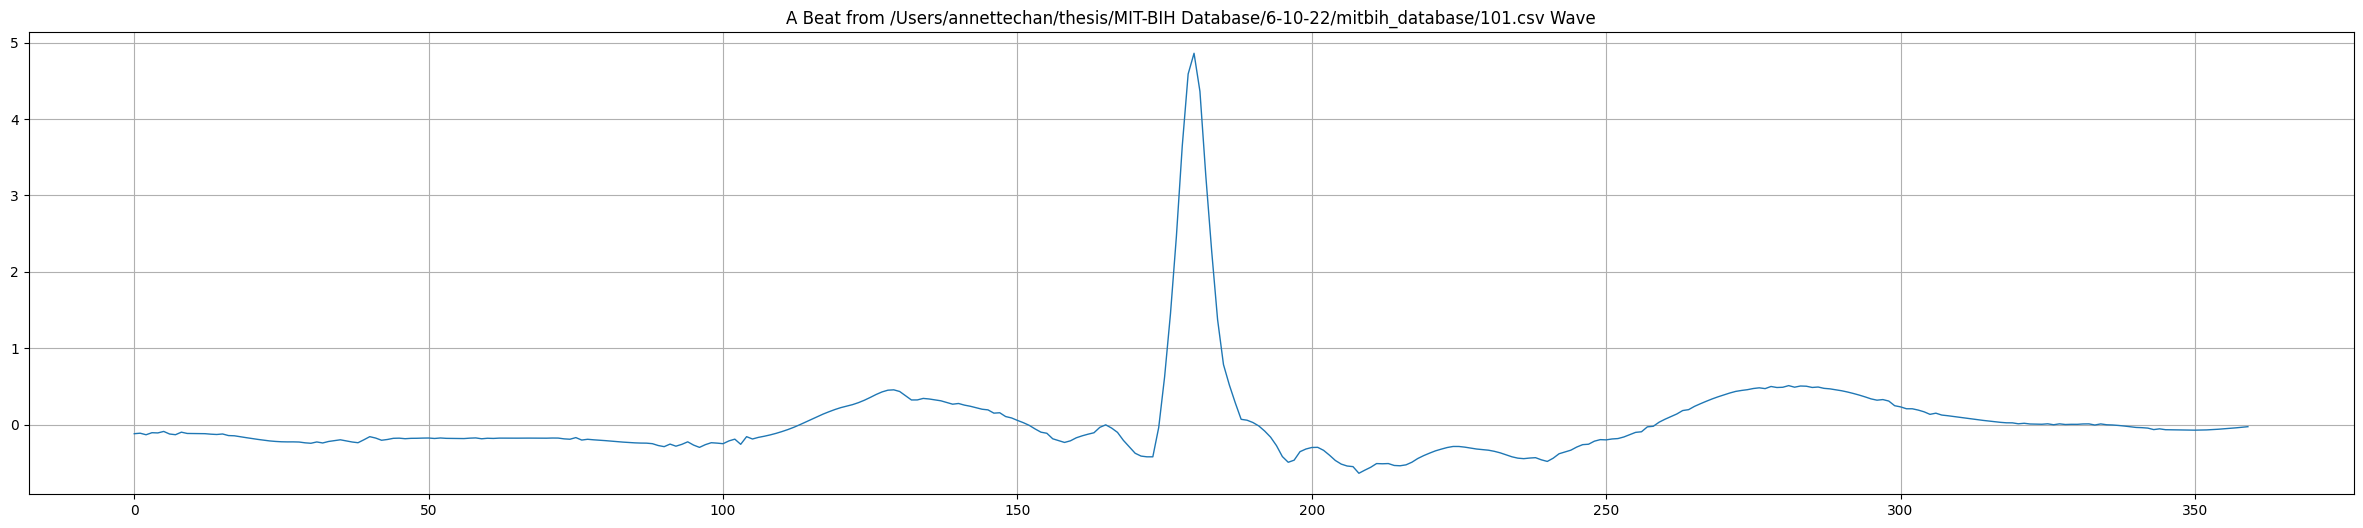

(100012, 360) (100012,)


In [6]:
#PRE-PROCESSING
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1

    # Plot an example to the signals
    if r == 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()

    signals = denoise(signals)
    # Plot an example to the signals
    if r == 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()

    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r == 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()

    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r == 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))

From the graph above, it can be seen that a lot of low frequency noise exists in the sample (i.e. baseline drift and powerline interference). 

In [7]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
        #X[i].append(y[i])

print(np.shape(X))

(100012, 361)


0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: 360, dtype: int64


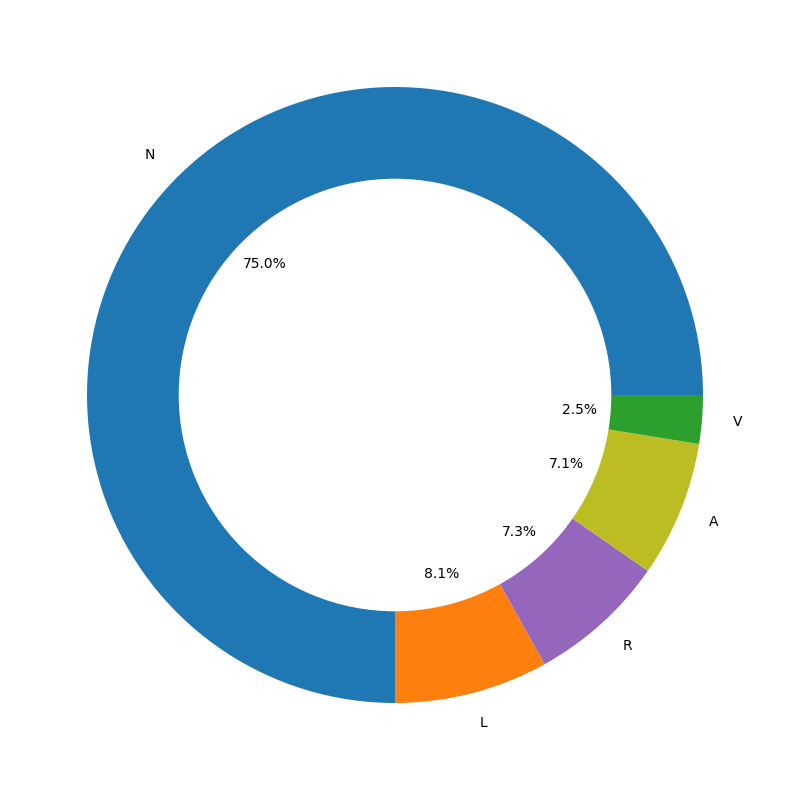

In [8]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [9]:
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (80009, 361)
X_test  :  (20003, 361)


In [10]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
#Due to multiclass classification, convert classifications in binary form
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(80009, 5) (20003, 5)


In [11]:
#Separate labels from feature values
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1])
test_x = test_x.reshape(len(test_x), test_x.shape[1])
print(np.shape(train_x), np.shape(test_x))

(80009, 360) (20003, 360)


In [12]:
#Apply PCA
pca = PCA(0.99)
#fit PCA on training set only
train_x = pca.fit_transform(train_x)
test_x = pca.transform(test_x)

In [13]:
print(pca.n_components_)
print(train_x.shape)
print(test_x.shape)

33
(80009, 33)
(20003, 33)


(-189.84717553187846,
 195.8913402307296,
 -56.175218794762046,
 75.45622127081576)

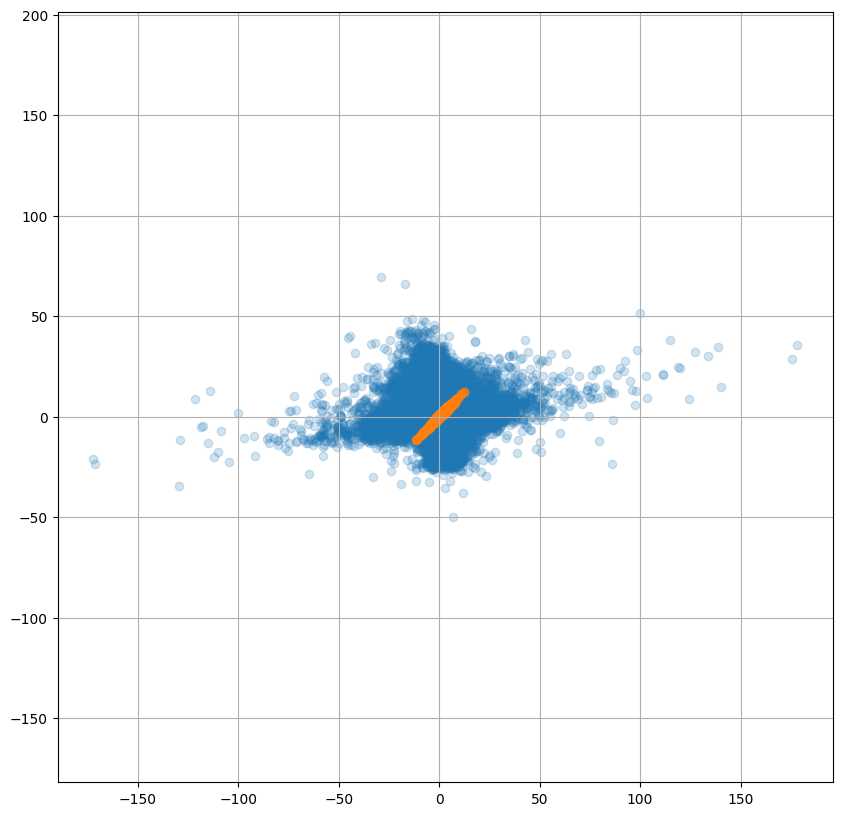

In [30]:
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 
X_train_new = pca.inverse_transform(train_x)
plt.scatter(train_x[:, 0], train_x[:, 1], alpha=0.2)
plt.scatter(X_train_new[:, 0],X_train_new[:, 1], alpha=0.8)
plt.axis('equal')

(-200.22369597377573,
 152.67552835312995,
 -33.207145585457894,
 50.92307362016675)

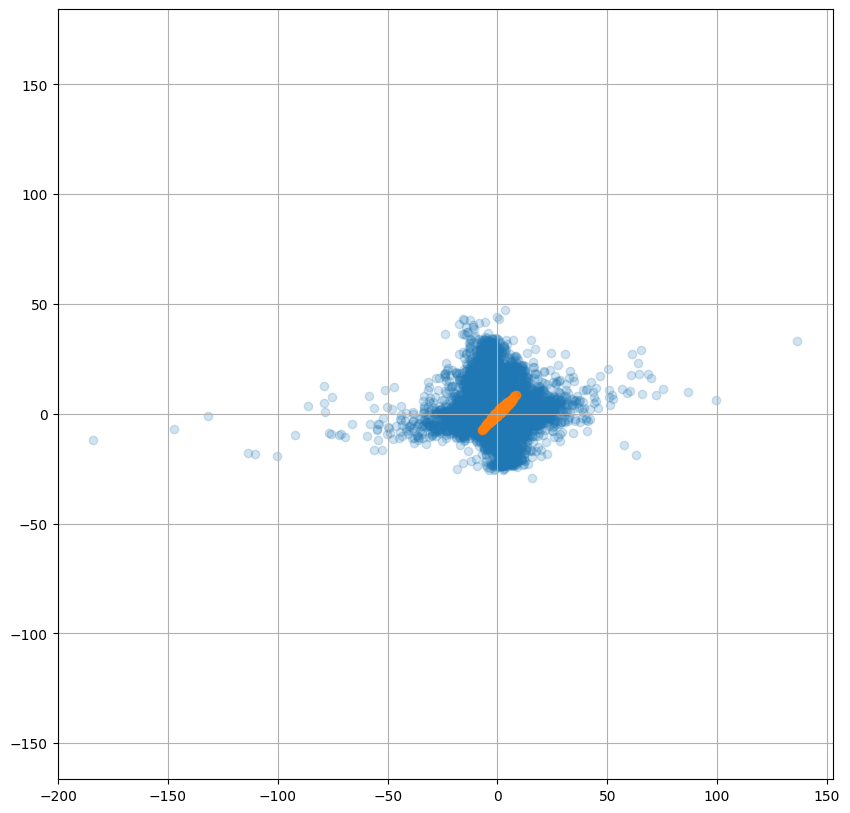

In [31]:
X_test_new = pca.inverse_transform(test_x)
plt.scatter(test_x[:, 0], test_x[:, 1], alpha=0.2)
plt.scatter(X_test_new[:, 0],X_test_new[:, 1], alpha=0.8)
plt.axis('equal')

In [14]:
#MODEL ARCHITECTURE
input_size = train_x.shape[1]
hidden_size = 6500

input_weights = np.random.normal(size=[input_size,hidden_size])
#biases = np.random.normal(size=[hidden_size])
print('Input Weight shape: {shape}'.format(shape=input_weights.shape))

Input Weight shape: (33, 6500)


In [15]:
#RELU has hidden layer activation function
def relu(x):
    return np.maximum(x,0,x)

In [16]:
def hidden_nodes(X):
    G = np.dot(X, input_weights)
    #G = G + biases
    H = relu(G)
    return H

In [17]:
X = hidden_nodes(train_x)
Xt = np.transpose(X)
output_weights = np.dot(np.linalg.inv(np.dot(Xt,X)), np.dot(Xt,train_y))
print('Output weights shape: {shape}'.format(shape=output_weights.shape))

Output weights shape: (6500, 5)


In [18]:
#predict the model
def predict(X):
    out = hidden_nodes(X)
    out = np.dot(out,output_weights)
    return out

In [19]:
#test the model
prediction = predict(test_x)
correct = 0
total = test_x.shape[0]
for i in range(total):
    predicted = np.argmax(prediction[i])
    actual = np.argmax(test_y[i])
    correct = correct + (1 if predicted == actual else 0)
accuracy = correct/total
print('Accuracy for ', hidden_size, ' hidden nodes: ', accuracy)

Accuracy for  6500  hidden nodes:  0.9857521371794231


In [20]:
#print confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_pred=np.argmax(prediction, axis=1)
y_test=np.argmax(test_y, axis=1)
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)
print('\nAccuracy: {:.4f}\n'.format(accuracy_score(y_test, y_pred)))
print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

FP = confusion.sum(axis=0) - np.diag(confusion)  
FN = confusion.sum(axis=1) - np.diag(confusion)
TP = np.diag(confusion)
TN = confusion.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Fall out or false positive rate
FPR = FP/(FP+TN)

print("False Positive Rate: ",FPR)

Confusion Matrix

[[14966     9     9    19    17]
 [   20  1597     0     0     3]
 [   14     0  1406     0     0]
 [   82     0     7   393     2]
 [   91     8     1     3  1356]]

Accuracy: 0.9858

Micro Precision: 0.99
Micro Recall: 0.99
Micro F1-score: 0.99

Macro Precision: 0.98
Macro Recall: 0.94
Macro F1-score: 0.96

Weighted Precision: 0.99
Weighted Recall: 0.99
Weighted F1-score: 0.99
False Positive Rate:  [0.04154124 0.00092477 0.00091481 0.00112711 0.00118637]


In [32]:
FNR = FN / (FN+TP)
print(FNR)

[0.00359521 0.01419753 0.00985915 0.18801653 0.0705963 ]


In [21]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['N', 'L', 'R', 'A', 'V'], digits=4))


Classification Report

              precision    recall  f1-score   support

           N     0.9864    0.9964    0.9914     15020
           L     0.9895    0.9858    0.9876      1620
           R     0.9881    0.9901    0.9891      1420
           A     0.9470    0.8120    0.8743       484
           V     0.9840    0.9294    0.9559      1459

    accuracy                         0.9858     20003
   macro avg     0.9790    0.9427    0.9597     20003
weighted avg     0.9856    0.9858    0.9855     20003

